In [1]:
import pandas as pd
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel , SelectKBest , mutual_info_classif
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder , OrdinalEncoder , LabelEncoder , StandardScaler , PolynomialFeatures
from sklearn.pipeline import make_pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from category_encoders import BinaryEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB , GaussianNB , BernoulliNB
from sklearn.svm import SVC , LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score , precision_score , f1_score , confusion_matrix , ConfusionMatrixDisplay
from sklearn.ensemble import AdaBoostClassifier , GradientBoostingClassifier , VotingClassifier , BaggingClassifier , RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate , GridSearchCV , StratifiedKFold , cross_val_predict
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv('Prepocessd_horse_ratings.csv')

In [23]:
df

,won,horse_age,horse_country,horse_gear,actual_weight,draw,trainer_id,jockey_id,venue,config,year,month,day,total_wins,win_rate_jockey,win_rate_trainer,win_rate,avg_finish_position,finish_time_trend
0,0,3,AUS,--,133,7,118,2,ST,A,1997,6,Monday,2,0.149523,0.140768,0.222222,7.566667,0.342868
1,0,3,NZ,--,133,12,164,57,ST,A,1997,6,Monday,2,0.088795,0.083400,0.000000,7.937500,0.348990
2,0,3,NZ,--,132,8,137,18,ST,A,1997,6,Monday,2,0.124434,0.097674,0.000000,5.681818,0.120649
3,0,3,Other,--,127,13,80,59,ST,A,1997,6,Monday,0,0.092593,0.084547,0.000000,8.857143,3.214643
4,0,3,Other,--,131,14,9,154,ST,A,1997,6,Monday,0,0.056800,0.056887,0.000000,5.500000,1.413147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73838,0,5,AUS,other,122,6,73,40,ST,A,2005,8,Sunday,3,0.060181,0.083534,0.285714,4.538462,0.353306
73839,0,5,NZ,--,119,4,164,63,ST,A,2005,8,Sunday,2,0.053220,0.083400,0.000000,5.482759,0.756591
73840,0,5,NZ,other,120,1,111,68,ST,A,2005,8,Sunday,1,0.045198,0.085007,0.000000,5.071429,1.674747
73841,0,3,AUS,--,119,12,118,95,ST,A,2005,8,Sunday,1,0.235056,0.140768,0.500000,4.500000,27.050000


In [3]:
x , y = df.drop('won',axis=1) , df['won']

In [25]:
for col in df.select_dtypes('object').columns:
    print(col,df[col].nunique())

horse_country 3
horse_gear 2
venue 2
config 6
day 7


Plan of pipeline :
1- Fill null values in horse_country and encode it with binary encoder
2- Encode config , horse_ratings with binary encoder
3- Encode day with oridinal encode
4- Fill null values in rating_bins and encodevit with ordinal encoder
5- Encode horse_gear , veneu with one hot encoder
6- All of that plus numeric column and make it standard scaler
7- Go into the model

In [4]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']


cat_null_be_pl=make_pipeline(SimpleImputer(strategy='most_frequent'),BinaryEncoder())
cat_be_pl=make_pipeline(BinaryEncoder())
cat_ord_pl_day=make_pipeline(OrdinalEncoder(categories=[day_order]))
cat_ohe_pl=make_pipeline(OneHotEncoder(sparse_output=False,drop='first',handle_unknown='ignore'))
num_imp=make_pipeline(SimpleImputer(strategy='median'))

In [5]:
cat_preprocessing=ColumnTransformer(transformers=[
    ('cat_null_be_pl',cat_null_be_pl,['horse_country']),
    ('cat_be_pl',cat_be_pl,['config']),
    ('cat_ord_pl_day',cat_ord_pl_day,['day']),
    ('cat_ohe_pl',cat_ohe_pl,['horse_gear','venue']),
    ('num_imp',num_imp,['finish_time_trend'])
],remainder='passthrough')

In [6]:
cat_preprocessing

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat_null_be_pl',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('binaryencoder',
                                                  BinaryEncoder())]),
                                 ['horse_country']),
                                ('cat_be_pl',
                                 Pipeline(steps=[('binaryencoder',
                                                  BinaryEncoder())]),
                                 ['config']),
                                ('cat_ord_pl_day',
                                 Pipeline(steps=[('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Monday',
                                                                              'Tuesday',
                                                                              'Wednesday',
                                                                              'Thursday',
                                                                              'Friday',
                                                                              'Saturday',
                                                                              'Sunday']]))]),
                                 ['day']),
                                ('cat_ohe_pl',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['horse_gear', 'venue']),
                                ('num_imp',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['finish_time_trend'])])

In [7]:
make_pipeline(cat_preprocessing,StandardScaler())

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_null_be_pl',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('binaryencoder',
                                                                   BinaryEncoder())]),
                                                  ['horse_country']),
                                                 ('cat_be_pl',
                                                  Pipeline(steps=[('binaryencoder',
                                                                   BinaryEncoder())]),
                                                  ['config']),
                                                 ('cat_ord_pl_day',
                                                  Pipeline(steps=...
                                                                                               'Wednesday',
                                                                                               'Thursday',
                                                                                               'Friday',
                                                                                               'Saturday',
                                                                                               'Sunday']]))]),
                                                  ['day']),
                                                 ('cat_ohe_pl',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['horse_gear', 'venue']),
                                                 ('num_imp',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['finish_time_trend'])])),
                ('standardscaler', StandardScaler())])

In [30]:
models = [
    LogisticRegression(class_weight='balanced'),
    KNeighborsClassifier(),
    GaussianNB(),
    LinearSVC(),
    DecisionTreeClassifier(class_weight='balanced'),
    RandomForestClassifier(class_weight='balanced'),
    AdaBoostClassifier(),
    VotingClassifier(estimators=[
        ('lr', LogisticRegression()),
        ('rf', RandomForestClassifier(max_depth=10)),
        ('xgb', XGBClassifier())
    ],
    voting='soft'),
    GradientBoostingClassifier(),
    XGBClassifier()
]

In [31]:
df['won'].value_counts()

won
0    67872
1     5971
Name: count, dtype: int64

In [12]:
## This is imbalanced data so we will use f1 score to coomputer the score

In [13]:
for model in models:
    pl = Pipeline([
        ('cat_preprocessing', cat_preprocessing),
        ('scaler', StandardScaler()),
        ('smote', SMOTE(sampling_strategy=0.4)),
        ('classifier', model)
    ])
    
    scores=cross_validate(estimator=pl,X=x, y=y ,cv=StratifiedKFold(n_splits=5),scoring='f1',return_train_score=True)
    
     # Get the classifier's class name
    model_name = pl.named_steps['classifier'].__class__.__name__
    print(model_name)
    print(f'Train avg f1 score : {scores["train_score"].mean()}')
    print(f'Test avg f1 score : {scores["test_score"].mean()}')
    print('*'*10)

LogisticRegression
Train avg f1 score : 0.49248810598028764
Test avg f1 score : 0.490760485459805
**********
KNeighborsClassifier
Train avg f1 score : 0.6622216975915911
Test avg f1 score : 0.3963871259370998
**********
GaussianNB
Train avg f1 score : 0.45574966560801045
Test avg f1 score : 0.4328223446238918
**********
LinearSVC
Train avg f1 score : 0.5187433690666043
Test avg f1 score : 0.515201114086984
**********
DecisionTreeClassifier
Train avg f1 score : 1.0
Test avg f1 score : 0.378860627454037
**********
RandomForestClassifier
Train avg f1 score : 1.0
Test avg f1 score : 0.4083781356510441
**********
AdaBoostClassifier
Train avg f1 score : 0.49258355922567576
Test avg f1 score : 0.48558937376758476
**********
VotingClassifier
Train avg f1 score : 0.5746828571167137
Test avg f1 score : 0.5065063704124622
**********
GradientBoostingClassifier
Train avg f1 score : 0.49720184898084974
Test avg f1 score : 0.49413167827388127
**********
XGBClassifier
Train avg f1 score : 0.6006803680

Train avg f1 score : 0.5898475086764225
Test avg f1 score : 0.4198205593619148
0.5120976104676808


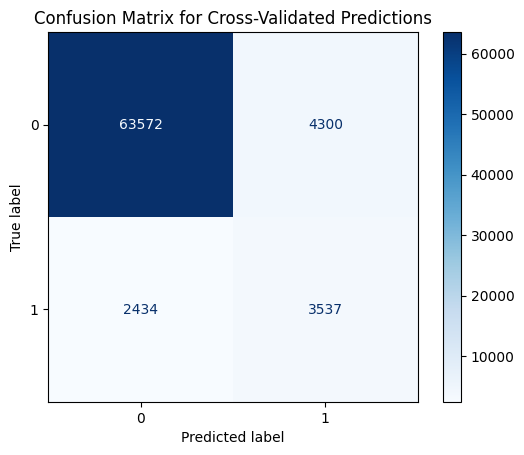

In [14]:
pl = Pipeline([
    ('cat_preprocessing', cat_preprocessing),
    ('scaler', StandardScaler()),
    ('smote', SMOTE(sampling_strategy=0.4)),
    ('classifier', XGBClassifier())
])

scores=cross_validate(estimator=pl,X=x, y=y ,cv=StratifiedKFold(n_splits=5),scoring='f1',return_train_score=True)

print(f'Train avg f1 score : {scores["train_score"].mean()}')
print(f'Test avg f1 score : {scores["test_score"].mean()}')

## We will mkae tunning in XGBClassifier
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.8, 1.0]
}

srch=GridSearchCV(estimator=pl,param_grid=param_grid,scoring='f1',cv=StratifiedKFold(n_splits=5),return_train_score=True)

srch.fit(x,y)

print(srch.best_score_)

# Get cross-validation predictions
y_pred = cross_val_predict(srch.best_estimator_, x, y, cv=5)

# Generate and display the confusion matrix
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for Cross-Validated Predictions')
plt.show()

Train avg f1 score : 0.5185871364195738
Test avg f1 score : 0.5159489809272151
0.5168995587723257


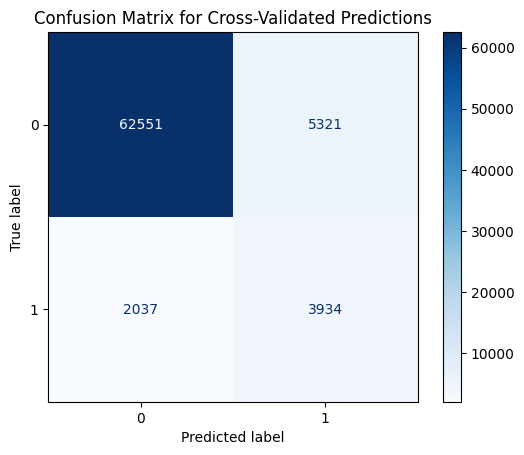

In [15]:
### we will try linear svc
param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__loss': ['hinge', 'squared_hinge'],
    'classifier__tol': [1e-4, 1e-3]
}
pl = Pipeline([
    ('cat_preprocessing', cat_preprocessing),
    ('scaler', StandardScaler()),
    ('smote', SMOTE(sampling_strategy=0.4)),
    ('classifier', LinearSVC())
])

scores=cross_validate(estimator=pl,X=x, y=y ,cv=StratifiedKFold(n_splits=5),scoring='f1',return_train_score=True)

print(f'Train avg f1 score : {scores["train_score"].mean()}')
print(f'Test avg f1 score : {scores["test_score"].mean()}')

srch=GridSearchCV(estimator=pl,param_grid=param_grid,scoring='f1',cv=StratifiedKFold(n_splits=5),return_train_score=True)
srch.fit(x,y)

print(srch.best_score_)


# Get cross-validation predictions
y_pred = cross_val_predict(srch.best_estimator_, x, y, cv=5)

# Generate and display the confusion matrix
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for Cross-Validated Predictions')
plt.show()

In [16]:
## I think this confusion matrix is better than the XGBClassifier

Train avg f1 score : 0.5166883738557387
Test avg f1 score : 0.49536576893954143
0.4995747823446487


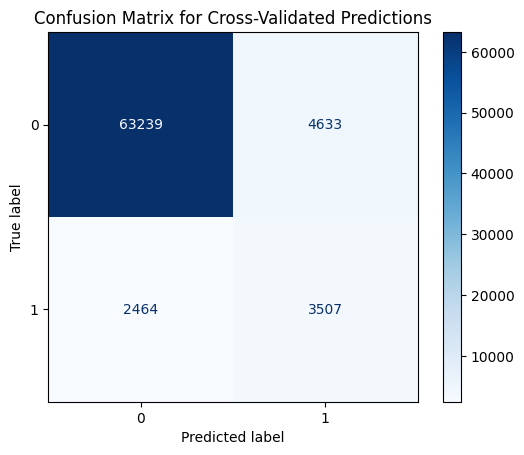

In [17]:
param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__loss': ['hinge', 'squared_hinge'],
    'classifier__tol': [1e-4, 1e-3]
}
pl = Pipeline([
    ('cat_preprocessing', cat_preprocessing),
    ('scaler', StandardScaler()),
    ('smote', SMOTE(sampling_strategy=0.4)),
    ('poly',PolynomialFeatures(degree=2)),
    ('classifier', LinearSVC())
])

scores=cross_validate(estimator=pl,X=x, y=y ,cv=StratifiedKFold(n_splits=5),scoring='f1',return_train_score=True)

print(f'Train avg f1 score : {scores["train_score"].mean()}')
print(f'Test avg f1 score : {scores["test_score"].mean()}')

srch=GridSearchCV(estimator=pl,param_grid=param_grid,scoring='f1',cv=StratifiedKFold(n_splits=5),return_train_score=True)

srch.fit(x,y)

print(srch.best_score_)

# Get cross-validation predictions
y_pred = cross_val_predict(srch.best_estimator_, x, y, cv=5)

# Generate and display the confusion matrix
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for Cross-Validated Predictions')
plt.show()

In [18]:
### so linearsvc without polyinomial is better

Train avg f1 score : 0.7762867290687165
Test avg f1 score : 0.49837591563105443
0.5066705766216045


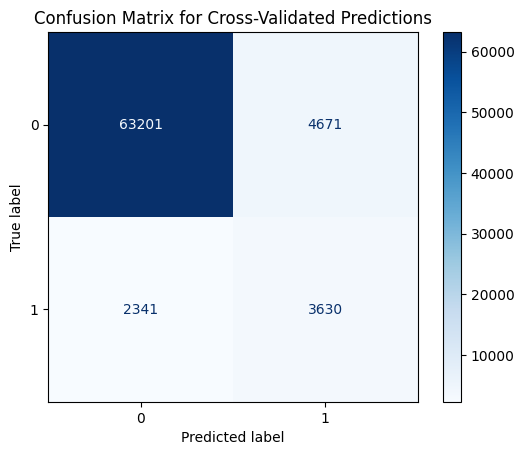

In [19]:
## We will see the Voting classifier 
param_grid = {
    'classifier__weights': [[1, 2, 1], [1, 1, 1], [2, 1, 1]]  # Example weights
}
# Define the base models for the VotingClassifier
estimators = [
    ('lr', LogisticRegression()),
    ('rf', RandomForestClassifier()),
    ('xg', XGBClassifier())  # Enable probabilities for 'soft' voting
]

pl = Pipeline([
    ('cat_preprocessing', cat_preprocessing),
    ('scaler', StandardScaler()),
    ('smote', SMOTE(sampling_strategy=0.4)),
    ('classifier', VotingClassifier(estimators=estimators, voting='soft'))
])

scores=cross_validate(estimator=pl,X=x, y=y ,cv=StratifiedKFold(n_splits=5),scoring='f1',return_train_score=True)

print(f'Train avg f1 score : {scores["train_score"].mean()}')
print(f'Test avg f1 score : {scores["test_score"].mean()}')

srch=GridSearchCV(estimator=pl,param_grid=param_grid,scoring='f1',cv=StratifiedKFold(n_splits=5),return_train_score=True)

srch.fit(x,y)

print(srch.best_score_)

y_pred = cross_val_predict(srch.best_estimator_, x, y, cv=5)

# Generate and display the confusion matrix
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for Cross-Validated Predictions')
plt.show()

Train avg f1 score : 0.8444500049688699
Test avg f1 score : 0.4749489327469266
0.4866619498270287


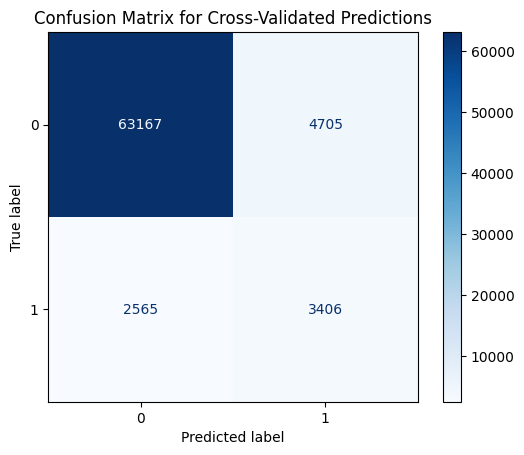

In [32]:
## voting classifier with poly
param_grid = {
    'classifier__weights': [[1, 2, 1], [1, 1, 1], [2, 1, 1]]  # Example weights
}
# Define the base models for the VotingClassifier
estimators = [
    ('lr', LogisticRegression()),
    ('rf', RandomForestClassifier()),
    ('xg', XGBClassifier())  # Enable probabilities for 'soft' voting
]

pl = Pipeline([
    ('cat_preprocessing', cat_preprocessing),
    ('scaler', StandardScaler()),
    ('smote', SMOTE(sampling_strategy=0.4)),
    ('poly',PolynomialFeatures(degree=2)),
    ('classifier', VotingClassifier(estimators=estimators, voting='soft'))
])

scores=cross_validate(estimator=pl,X=x, y=y ,cv=StratifiedKFold(n_splits=5),scoring='f1',return_train_score=True)

print(f'Train avg f1 score : {scores["train_score"].mean()}')
print(f'Test avg f1 score : {scores["test_score"].mean()}')

srch=GridSearchCV(estimator=pl,param_grid=param_grid,scoring='f1',cv=StratifiedKFold(n_splits=5),return_train_score=True)

srch.fit(x,y)

print(srch.best_score_)

y_pred = cross_val_predict(srch.best_estimator_, x, y, cv=5)

# Generate and display the confusion matrix
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for Cross-Validated Predictions')
plt.show()

Train avg f1 score : 0.5158499414092783
Test avg f1 score : 0.4967756485625429
0.5183489372008784


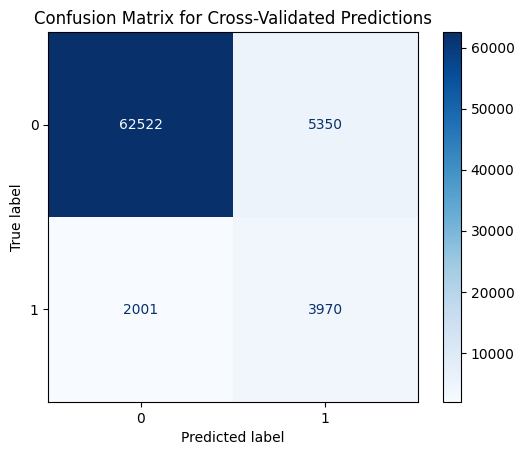

In [8]:
## LOGISTIC REGRESSION classifier
param_grid = {
    'classifier__C': [0.1,0.5,1,5,10],
    'poly__degree': [1,2, 3, 4],
}

pl = Pipeline([
    ('cat_preprocessing', cat_preprocessing),
    ('scaler', StandardScaler()),
    ('smote', SMOTE(sampling_strategy=0.4)),
    ('poly',PolynomialFeatures()),
    ('classifier', LogisticRegression())
])

scores = cross_validate(
    estimator=pl,
    X=x,
    y=y,
    cv=StratifiedKFold(n_splits=5),
    scoring='f1',
    return_train_score=True)

print(f'Train avg f1 score : {scores["train_score"].mean()}')
print(f'Test avg f1 score : {scores["test_score"].mean()}')

srch=GridSearchCV(estimator=pl,param_grid=param_grid,scoring='f1',cv=StratifiedKFold(n_splits=5),return_train_score=True)

srch.fit(x,y)

print(srch.best_score_)

y_pred = cross_val_predict(srch.best_estimator_, x, y, cv=5)

# Generate and display the confusion matrix
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for Cross-Validated Predictions')
plt.show()

Train avg f1 score : 0.5150834980268548
Test avg f1 score : 0.4908309054265468
0.5183641960732475


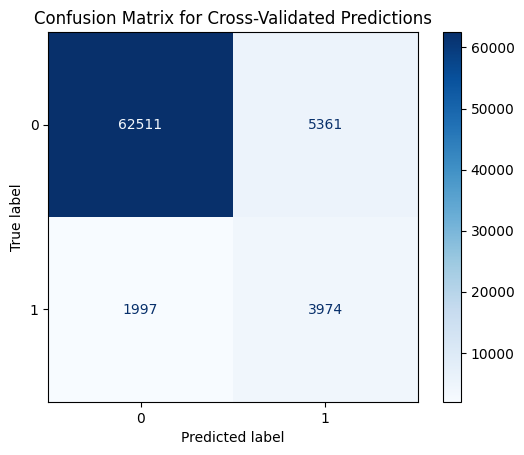

In [39]:
## LOGISTIC REGRESSION classifier
param_grid = {
    'classifier__C': [0.1,0.5,1,5,10],
    'poly__degree': [1,2, 3, 4],
}

pl = Pipeline([
    ('cat_preprocessing', cat_preprocessing),
    ('scaler', StandardScaler()),
    ('smote', SMOTE(sampling_strategy=0.4)),
    ('poly',PolynomialFeatures()),
    ('classifier', LogisticRegression())
])

scores = cross_validate(
    estimator=pl,
    X=x,
    y=y,
    cv=StratifiedKFold(n_splits=5),
    scoring='f1',
    return_train_score=True)

print(f'Train avg f1 score : {scores["train_score"].mean()}')
print(f'Test avg f1 score : {scores["test_score"].mean()}')

srch=GridSearchCV(estimator=pl,param_grid=param_grid,scoring='f1',cv=StratifiedKFold(n_splits=5),return_train_score=True)

srch.fit(x,y)

print(srch.best_score_)

y_pred = cross_val_predict(srch.best_estimator_, x, y, cv=5)

# Generate and display the confusion matrix
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for Cross-Validated Predictions')
plt.show()

In [9]:
### I think the best is Logistic regression so i will take this model and make it depolyment in streamlit 
import joblib
joblib.dump(srch.best_estimator_, 'pipeline.h5')
joblib.dump(x.columns,'datafeature.h5')

['datafeature.h5']